# 0 - Analyse Dataset

In [ ]:
# @title Paramètres globaux
PATH = "/drive/My Drive/Colab Notebooks/C4/tp4/avmnist" # @param {type:"string"}
uncompress = False # @param {type:"boolean"}
retrain_networks = True # @param {type:"boolean"}


In [ ]:
## uncompress dataset
from google.colab import drive
drive.mount('/drive',force_remount = True)
if uncompress:
  !tar -xzf "/drive/My Drive/Colab Notebooks/C4/tp4/avmnist.tar.gz"

Mounted at /drive


In [ ]:
###
!pip install torchmetrics

In [ ]:
###
import sys
import os
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

from torchmetrics import Accuracy
from tqdm.notebook import tqdm

In [ ]:
# @title Chargement des donnees audio et video
train_shuffle = True # @param {type:"boolean"}
flatten_audio=False # @param {type:"boolean"}
flatten_image=False # @param {type:"boolean"}
unsqueeze_channel=True # @param {type:"boolean"}
normalize_image=True # @param {type:"boolean"}
normalize_audio=True # @param {type:"boolean"}
batch_size=40 # @param {type:"integer"}
num_workers=8 # @param {type:"integer"}

data_dir = PATH
traindata = [np.load(data_dir+"/image/train_data.npy"),
             np.load(data_dir + "/audio/train_data.npy"),
             np.load(data_dir+"/train_labels.npy")]
testdata = [np.load(data_dir+"/image/test_data.npy"),
            np.load(data_dir + "/audio/test_data.npy"),
            np.load(data_dir+"/test_labels.npy")]

if flatten_audio:
    traindata[1] = traindata[1].reshape(60000, 112*112)
    testdata[1] = testdata[1].reshape(10000, 112*112)

if normalize_image:
    traindata[0] /= 255.0
    testdata[0] /= 255.0
if normalize_audio:
    traindata[1] = traindata[1]/255.0
    testdata[1] = testdata[1]/255.0
if not flatten_image:
    traindata[0] = traindata[0].reshape(60000, 28, 28)
    testdata[0] = testdata[0].reshape(10000, 28, 28)
if unsqueeze_channel:
    traindata[0] = np.expand_dims(traindata[0], 1)
    testdata[0] = np.expand_dims(testdata[0], 1)
    traindata[1] = np.expand_dims(traindata[1], 1)
    testdata[1] = np.expand_dims(testdata[1], 1)

traindata[0] = traindata[0].astype(float)
testdata[0] = testdata[0].astype(float)
traindata[2] = traindata[2].astype(int)
testdata[2] = testdata[2].astype(int)

trainlist = [[traindata[j][i] for j in range(3)] for i in range(60000)]
testlist = [[testdata[j][i] for j in range(3)] for i in range(10000)]

In [ ]:
### create dataloaders
validdata = DataLoader(trainlist[55000:60000], shuffle=False,
                        num_workers=num_workers, batch_size=batch_size)
testdata = DataLoader(testlist, shuffle=False,
                       num_workers=num_workers, batch_size=batch_size)
traindata = DataLoader(trainlist[0:55000], shuffle=train_shuffle,
                        num_workers=num_workers, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training Samples:


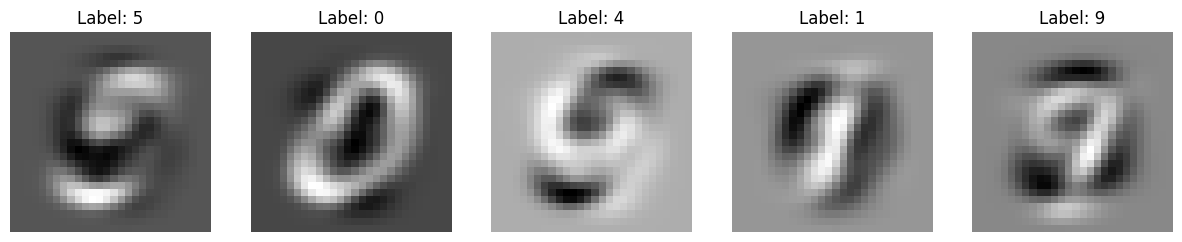

Testing Samples:


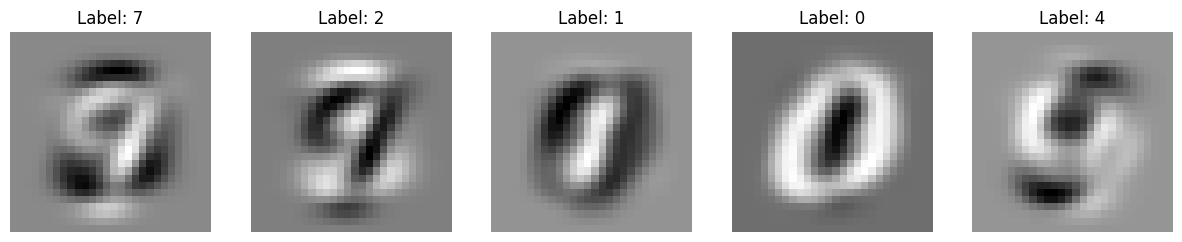

In [ ]:
## show some data

# Function to display images and their labels
def show_images_with_labels(data_list, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))  # Adjust figsize as needed

    for i in range(num_samples):
        image, audio, label = data_list[i]

        # Display the image
        axes[i].imshow(image[0], cmap='gray')  # Assuming images are grayscale
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Display training samples
print("Training Samples:")
show_images_with_labels(trainlist)

# Display testing samples
print("Testing Samples:")
show_images_with_labels(testlist)



Ce dataset est beaucoup plus compliqué que le MNIST standard, les images sont de dificile identification même pour les humains.

# 1 - Classifieurs Unimodaux

## LeNet5 pour l'image

In [ ]:
class LeNet5_im(nn.Module):
    def __init__(self):
        super(LeNet5_im, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data[0].to(device, dtype=torch.float)
        labels = data[2].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data[0].to(device, dtype=torch.float)
            labels = data[2].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [ ]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet5_im()
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

if retrain_networks:
  for epoch in range(num_epochs):
      train_loss, train_acc = train_model(model,traindata, criterion, optimizer,device)
      val_loss, val_acc = evaluate_model(model, validdata, criterion,device)
      print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

      if val_acc > best_score :
        best_epoch = epoch
        best_score = val_acc
        torch.save(model,'best_model_lenet5_im.pth')

# Test the trained model
best_model = torch.load('best_model_lenet5_im.pth').to(device)

if retrain_networks:
  test_loss, test_acc = evaluate_model(best_model, testdata, criterion,device)
  print('Best Epoch',best_epoch+1)
  print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/1375 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 1.2512 - Train Acc: 52.68% - Val Loss: 0.9214 - Val Acc: 64.38%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.9876 - Train Acc: 61.40% - Val Loss: 0.8876 - Val Acc: 64.54%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.9552 - Train Acc: 62.41% - Val Loss: 0.8590 - Val Acc: 66.14%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.9335 - Train Acc: 63.32% - Val Loss: 0.8464 - Val Acc: 66.82%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.9180 - Train Acc: 63.82% - Val Loss: 0.8385 - Val Acc: 67.02%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.9078 - Train Acc: 64.15% - Val Loss: 0.8213 - Val Acc: 67.42%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.9001 - Train Acc: 64.58% - Val Loss: 0.8154 - Val Acc: 69.00%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.8939 - Train Acc: 64.52% - Val Loss: 0.8218 - Val Acc: 67.92%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.8900 - Train Acc: 64.79% - Val Loss: 0.8103 - Val Acc: 68.54%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.8858 - Train Acc: 64.97% - Val Loss: 0.8150 - Val Acc: 68.68%


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Best Epoch 7
Test Loss: 0.9038 - Test Acc: 64.09%


In [ ]:
model = LeNet5_im()
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 61706


## LeNet5 pour l'audio

In [ ]:
class LeNet5_au(nn.Module):
    def __init__(self):
        super(LeNet5_au, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(24, 32, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(32 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Function for training the model
def train_model_au(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data[1].to(device, dtype=torch.float)
        labels = data[2].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model_au(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data[1].to(device, dtype=torch.float)
            labels = data[2].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [ ]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet5_au()
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

if retrain_networks:
  for epoch in range(num_epochs):
      train_loss, train_acc = train_model_au(model,traindata, criterion, optimizer,device)
      val_loss, val_acc = evaluate_model_au(model, validdata, criterion,device)
      print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

      if val_acc > best_score :
        best_epoch = epoch
        best_score = val_acc
        torch.save(model,'best_model_lenet5_au.pth')

# Test the trained model
best_model = torch.load('best_model_lenet5_au.pth').to(device)

if retrain_networks:
  test_loss, test_acc = evaluate_model_au(best_model, testdata, criterion,device)
  print('Best Epoch',best_epoch+1)
  print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 2.2235 - Train Acc: 20.33% - Val Loss: 2.1680 - Val Acc: 26.94%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 2.0791 - Train Acc: 35.04% - Val Loss: 2.0822 - Val Acc: 35.20%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 2.0272 - Train Acc: 38.78% - Val Loss: 2.0509 - Val Acc: 38.64%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 2.0008 - Train Acc: 40.74% - Val Loss: 2.0329 - Val Acc: 39.08%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 1.9853 - Train Acc: 41.57% - Val Loss: 2.0296 - Val Acc: 39.72%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 1.9736 - Train Acc: 42.03% - Val Loss: 2.0208 - Val Acc: 40.14%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 1.9653 - Train Acc: 42.44% - Val Loss: 2.0116 - Val Acc: 40.70%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 1.9581 - Train Acc: 42.81% - Val Loss: 2.0075 - Val Acc: 40.68%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 1.9521 - Train Acc: 42.93% - Val Loss: 2.0072 - Val Acc: 40.84%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 1.9471 - Train Acc: 43.21% - Val Loss: 2.0057 - Val Acc: 41.20%


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Best Epoch 10
Test Loss: 2.0112 - Test Acc: 39.65%


In [ ]:
model = LeNet5_au()
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 77122


# 2 - En amont

In [ ]:
class LeNet5_full(nn.Module):
    def __init__(self):
        super(LeNet5_full, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(24, 32, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(32 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Function for training the model
def train_model_full(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        upscaled_image = F.interpolate(data[0].to(device, dtype=torch.float), size=(112, 112), mode='bilinear', align_corners=False)
        inputs = torch.cat((upscaled_image, data[1].to(device, dtype=torch.float)), dim=1)
        labels = data[2].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model_full(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            upscaled_image = F.interpolate(data[0].to(device, dtype=torch.float), size=(112, 112), mode='bilinear', align_corners=False)
            inputs = torch.cat((upscaled_image, data[1].to(device, dtype=torch.float)), dim=1)
            labels = data[2].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [ ]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet5_full()
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

if retrain_networks:
  for epoch in range(num_epochs):
      train_loss, train_acc = train_model_full(model,traindata, criterion, optimizer,device)
      val_loss, val_acc = evaluate_model_full(model, validdata, criterion,device)
      print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

      if val_acc > best_score :
        best_epoch = epoch
        best_score = val_acc
        torch.save(model,'best_model_lenet5_full.pth')

# Test the trained model
best_model = torch.load('best_model_lenet5_full.pth').to(device)

if retrain_networks:
  test_loss, test_acc = evaluate_model_full(best_model, testdata, criterion,device)
  print('Best Epoch',best_epoch+1)
  print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 1.1405 - Train Acc: 55.91% - Val Loss: 0.8758 - Val Acc: 65.82%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.9269 - Train Acc: 63.84% - Val Loss: 0.8211 - Val Acc: 68.18%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.8913 - Train Acc: 65.25% - Val Loss: 0.8157 - Val Acc: 68.68%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.8686 - Train Acc: 66.35% - Val Loss: 0.8022 - Val Acc: 68.68%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.8538 - Train Acc: 67.10% - Val Loss: 0.7687 - Val Acc: 70.16%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.8378 - Train Acc: 67.83% - Val Loss: 0.7763 - Val Acc: 70.32%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.8260 - Train Acc: 68.28% - Val Loss: 0.7749 - Val Acc: 69.60%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.8167 - Train Acc: 68.68% - Val Loss: 0.7539 - Val Acc: 71.38%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.8089 - Train Acc: 69.21% - Val Loss: 0.7583 - Val Acc: 70.86%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.8012 - Train Acc: 69.47% - Val Loss: 0.7590 - Val Acc: 71.56%


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Best Epoch 10
Test Loss: 0.8155 - Test Acc: 69.29%


In [ ]:
model = LeNet5_full()
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 79076


# 3 - Intermediaire

In [ ]:
class LeNet5_inter(nn.Module):
    def __init__(self):
        super(LeNet5_inter, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(24, 32, kernel_size=5, stride=1, padding=0)

        self.conv1_im = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2_im = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)

        self.fc1 = nn.Linear(16 * 5 * 5 + 32 * 3 * 3, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, y):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 3 * 3)

        y = F.relu(self.conv1_im(y))
        y = F.max_pool2d(y, kernel_size=2, stride=2)
        y = F.relu(self.conv2_im(y))
        y = F.max_pool2d(y, kernel_size=2, stride=2)
        y = y.view(-1, 16 * 5 * 5)

        cat = torch.cat([x,y], dim=1)

        cat = F.relu(self.fc1(cat))
        cat = self.fc3(cat)
        return cat

In [ ]:
# Function for training the model
def train_model_inter(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs0 = data[0].to(device, dtype=torch.float)
        inputs1 = data[1].to(device, dtype=torch.float)
        labels = data[2].to(device)
        optimizer.zero_grad()
        outputs = model(inputs1, inputs0)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model_inter(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs0 = data[0].to(device, dtype=torch.float)
            inputs1 = data[1].to(device, dtype=torch.float)
            labels = data[2].to(device)
            outputs = model(inputs1, inputs0)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [ ]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet5_inter()
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

if retrain_networks:
  for epoch in range(num_epochs):
      train_loss, train_acc = train_model_inter(model,traindata, criterion, optimizer,device)
      val_loss, val_acc = evaluate_model_inter(model, validdata, criterion,device)
      print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

      if val_acc > best_score :
        best_epoch = epoch
        best_score = val_acc
        torch.save(model,'best_model_lenet5_inter.pth')

# Test the trained model
#best_model = torch.load('best_model_lenet5_inter.pth').to(device)
best_model = model

if retrain_networks:
  test_loss, test_acc = evaluate_model_inter(best_model, testdata, criterion,device)
  print('Best Epoch',best_epoch+1)
  print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.9406 - Train Acc: 64.79% - Val Loss: 0.7647 - Val Acc: 71.26%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.7996 - Train Acc: 70.38% - Val Loss: 0.7330 - Val Acc: 72.90%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.7676 - Train Acc: 71.63% - Val Loss: 0.7166 - Val Acc: 73.18%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.7474 - Train Acc: 72.18% - Val Loss: 0.7290 - Val Acc: 73.44%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.7344 - Train Acc: 72.64% - Val Loss: 0.6940 - Val Acc: 74.80%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.7225 - Train Acc: 73.27% - Val Loss: 0.7041 - Val Acc: 74.36%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.7130 - Train Acc: 73.53% - Val Loss: 0.7015 - Val Acc: 73.72%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.7044 - Train Acc: 73.88% - Val Loss: 0.6919 - Val Acc: 74.36%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.6978 - Train Acc: 74.07% - Val Loss: 0.6963 - Val Acc: 74.60%


Training:   0%|          | 0/1375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.6902 - Train Acc: 74.40% - Val Loss: 0.6912 - Val Acc: 74.62%


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Best Epoch 5
Test Loss: 0.7595 - Test Acc: 71.84%


In [ ]:
model = LeNet5_inter()
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 92726


# 4 - Comparaison



| Type | # params (K) | Accuracy (%) |
| --- | --- | --- |
| Image only | 61,7 | 64,09 |
| Audio only | 77,1 | 39,65 |
| Early fusion | 79 | 69,29 |
| Intermediate fusion | 92,7 | 71,84 |

On observe d'abord que les données image contiennet de l'information plus utile/exploitable par le réseaux, comme le démontre une précision plus élevée pour le modèle ImageOnly par rapport à celui AudioOnly.

Ensuite, l'Early Fusion a été réalisée avec un nombre minimal de paramètres supplémentaires, entraînant une amélioration des performances.

La fusion intermediaire donc a été implementée mais le résultat n'est pas si bon que l'attendu. Le grand nombre de paramètres suplementaires se donne à cause de l'augumentation du layer fully connected (version initiale, 220K parameters et performance de 69% avec 3 couches FC). En adaptant la taille du layer FC, nous sommes arrivés donc à réduire significativement le nombre de paramètres, en amméliorant la performance. Par conséquence, on a finalement attendu une bonne performace intermediaire.

La fusion intermediaire donne un meilleur résultat que celle en ammont, ce qui nous semble comme un bon trade-off entre performance et nombre de paramètres.